## Softcosine Clusters

**Purpose:** cluster outlet articles based on softcosine similarity<br>
Code based on https://github.com/damian0604/newsevents/blob/master/src/analysis/clustering.ipynb

**Steps:**
1. merge pajek files into one file
2. define functions for transforming the files to a graph, partitioning the graph, analyzing it, etc.
3. conduct clustering
4. show clustering results, export clusters by similarity threshold to .jsonl

In [1]:
import os
from glob import glob
import json
from tqdm import tqdm
import leidenalg
import igraph as ig
import networkx as nx
import matplotlib.pyplot as plt
import pandas as pd
from pprint import pprint
%matplotlib inline

In [2]:
nx.__version__

'2.4'

In [3]:
net_dir = os.path.join("..", "..", "data", "02-intermediate", "07-newsevents", "02-softcosine-pkl2net")
netmerged_dir = os.path.join("..", "..", "data", "02-intermediate", "07-newsevents", "03-softcosine-netmerged")
fig_dir = os.path.join("..", "..", "data", "02-intermediate", "07-newsevents", "04-softcosine-figures")
clusters_dir = os.path.join("..", "..", "data", "02-intermediate", "07-newsevents", "05-softcosine-clusters", "jsonl")

In [4]:
# matplotlib is logged even though disable_existing_loggers=yes in logging_config.yaml
# https://stackoverflow.com/a/51529172/7016397
# workaround is to manually set the level before creating my logger
import logging
logging.getLogger('matplotlib').setLevel(logging.WARNING)

from usrightmedia.shared.loggers import get_logger
LOGGER = get_logger(filename = '03-softcosine-clustering', logger_type='main')

In [5]:
from inca import Inca
myinca=Inca()

2022-01-18 01:46:00,597 - [WARNING] - INCA - (hype_analysis.py).<module>(21) - $DISPLAY environment variable is not set, trying a different approach. You probably are running INCA on a text console, right?
2022-01-18 01:46:00,719 - [WARNING] - INCA - (var_tsa_analysis.py).<module>(21) - $DISPLAY environment variable is not set, trying a different approach. You probably are running INCA on a text console, right?


In [6]:
from usrightmedia.shared.es_queries import query_by_ids

### merge pajek files into one file

Modified original code due to networkx version difference ([migration guide](https://networkx.org/documentation/stable/release/migration_guide_from_1.x_to_2.0.html)):

- `AttributeError: 'MultiGraph' object has no attribute 'node' -> use G.nodes` ([link](https://networkx.org/documentation/stable/release/release_2.4.html#deprecations))
- `AttributeError: 'Graph' object has no attribute 'selfloop_edges' -> nx.selfloop_edges(graph)` ([link](https://github.com/JiaxuanYou/P-GNN/issues/16#issuecomment-633232539))
>The Graph attributes G.node and G.edge have been removed in favor of using G.nodes[n] and G.edges[u, v]. Finally, the selfloop methods and add_path/star/cycle have been moved from graph methods to networkx functions.

In [7]:
softcosine_files = glob(f"{net_dir}/*.net")

In [8]:
def merge_pajek_files(files, output_file):
    G = nx.Graph()
    for f in tqdm(files):
        H = nx.read_pajek(f)
        for node in H:         # remove all node properties, such as misleading/non-unique ids
            del H.nodes[node]['id']
            del H.nodes[node]['x']
            del H.nodes[node]['y']
            del H.nodes[node]['shape']
        G.update(H)
    print(f'{len(G.nodes)} nodes and {len(G.edges)} edges')
    print('Removing self loops...')
    G.remove_edges_from(list(nx.selfloop_edges(G))) # self-loops are due to the 'source' and 'target' being the same doc during INCA's softcosine analysis 
    print(f'{len(G.nodes)} nodes and {len(G.edges)} edges')
    nx.write_pajek(G, output_file)
    print(f'All written to {output_file}')
    return G

Gnxsoft = merge_pajek_files(softcosine_files, os.path.join(netmerged_dir, 'softcosine_merged.net'))
Gsoft = ig.read(os.path.join(netmerged_dir, 'softcosine_merged.net'), format='pajek')

100%|██████████| 1821/1821 [14:05<00:00,  2.15it/s]


727208 nodes and 13141595 edges
Removing self loops...
727208 nodes and 12415988 edges
All written to ../../data/02-intermediate/07-newsevents/03-softcosine-netmerged/softcosine_merged.net


### 2. Define functions
Functions for transforming the files to a graph, partitioning the graph, analyzing it, etc.

In [9]:
def partition_graph(G0, minedgeweight):
    '''takes an igraph, prunes it and partitions it. returns a list of partitions '''
    G = G0.copy()
    G.es.select(weight_le=minedgeweight).delete()
    part = leidenalg.find_partition(G, leidenalg.SurpriseVertexPartition)
    print(part.summary())
    partitions = []
    for subgraph in part.subgraphs():
         partitions.append([node['id'] for node in subgraph.vs])
    return partitions

In [10]:
def show_descriptives(results, filename=None):
    '''takes a list of lists (articles per clusters), plots a histogram and prints descriptives'''
    articles_per_cluster = [len(x) for x in results]
    single_article_clusters = sum([1 if e==1 else 0 for e in articles_per_cluster])
    multiple_article_clusters = len(articles_per_cluster) - single_article_clusters
    fig = plt.figure(figsize=(10,5))
    plt.hist(articles_per_cluster, bins = max(articles_per_cluster), color='#5ab4ac', alpha=0.8, log=True)
    if filename:
        plt.savefig(filename+'.png', dpi=400)
        # plt.savefig(filename+'.eps')
    plt.show()
    print(pd.Series(articles_per_cluster).describe())
    print(f'\nThere are {single_article_clusters} single-article clusters and {multiple_article_clusters} multiple-article clusters.')

In [11]:
def get_cluster_by_ids(ids, n_hits=10):
    '''Takes a list of IDs (associated with the same cluster) and retrieves the first n docs (n_hits) from ES.
       Returns a dict which includes three keys ('ids', 'total', 'docs')
           IDs and selected _source fields of the first n docs (n_hits) along with the total number of hits in ES.
    '''
    
    res = myinca.database._client.search(
        myinca.database._elastic_index,
        body=query_by_ids(ids=ids),
        _source=['title', 'publish_date'],
        sort='publish_date:asc',
        size=n_hits)
    
    res_dict = {}
    res_dict['cluster_size'] = res['hits']['total']
    hits = res['hits']['hits']
    
    for hit in hits:
        hit['_source']['_id'] = hit['_id']
    
    res_dict['docs'] = [hit['_source'] for hit in hits]

    return res_dict

In [12]:
def show_cluster_examples(results, n_clusters=1, n_hits=10):
    '''Prints cluster examples per softcosine threshold.
       It starts from the largest cluster (n_clusters=1).
       
       Args:
           results (list of lists): lists=clusters; each inner list is a set of IDs associated with the same cluster
           n_clusters (int): number of clusters to show
           n_hits (int): number of hits per cluster to show
           
    '''
    print('='*80)
    print(f"Showing {n_clusters} example cluster(s)...")
    print('-'*80)
    for n in range(0,n_clusters):
        cluster = get_cluster_by_ids(results[n], n_hits=n_hits)
        print(f"Example {n}: the cluster contains {cluster['cluster_size']} documents.")
        if len(cluster['docs']) == 1:
            print(f"Below is {len(cluster['docs'])} doc from the cluster.\n")
        else:
            print(f"Below are {len(cluster['docs'])} docs from the cluster.\n")
        print("Titles:\n")
        pprint([doc['title'] for doc in cluster['docs']])
        print("\nPublish dates:\n")
        pprint([doc['publish_date'] for doc in cluster['docs']])
        print("\nIDs:\n")
        pprint([doc['_id'] for doc in cluster['docs']])
        print(f"{'-'*80}\n")

In [13]:
def export_clusters_to_jsonl(results, similarity, minedgeweight):
    """For a given similarity-mindedgeweight combination, export the clustered docs to a .jsonl file.
    
    Args:
        results (list of lists): lists=clusters; each inner list is a set of IDs associated with the same cluster
        similarity (str): e.g.,'softcos'
        minedgeweight (int): e.g., 0.2
    
    """
    for n in range(0, len(results)):
        # 10,000 is ES search endpoint's size limit
        # if a cluster actually contains 10,000+ docs, it's probably more similar to a topic/theme than a specific news event
        cluster = get_cluster_by_ids(results[n], n_hits=10000)
    
        sim_weight = f"{similarity}{str(minedgeweight).replace('.', '')}"
        cluster['cluster_id'] = f"{sim_weight}_{n}"
        
        filename=f"clusters_{sim_weight}.jsonl"
        with open(file=os.path.join(clusters_dir, filename), mode="a", encoding="utf-8") as file:
            file.write(json.dumps(cluster) + "\n")
            
    print(f"Exported {len(results)} clusters to {filename}.")

In [14]:
def print_gridreport(gridresults, n_clusters=1, n_hits=10, export_clusters=True):
    for r in gridresults:
        l = r['results']
        flattened = [item for sublist in l for item in sublist]
        print(f"{r['similarity']}, threshold={r['minedgeweight']}: Found {len(flattened)} articles, out of which {len(set(flattened))} are unique articles")
    print('(hint: if *not* all articles are unique, then articles are assigned to multiple clusters)')
    print('\n')

    for r in gridresults:
        print("*"*80)
        similarity = r['similarity']
        minedgeweight = r['minedgeweight']
        fn = f"{similarity}{str(minedgeweight).replace('.','')}"
        results = r['results']
        print(f'Similarity metric: {similarity}\nMinimum edgeweight: {minedgeweight}\n')
        print("*"*80)
        show_descriptives(results, filename = f"{os.path.join(fig_dir, fn)}")
        show_cluster_examples(results, n_clusters=n_clusters, n_hits=n_hits)
        if export_clusters:
            export_clusters_to_jsonl(results, similarity, minedgeweight)
        print('\n\n')

### 3. Conduct clustering
Use a grid to vary the minimum edgeweight threshold (.2, .3, .4, .5, .6, .7, .8, .9)

In [15]:
grid = [('softcos', Gsoft, .2),
        ('softcos', Gsoft, .3),
        ('softcos', Gsoft, .4),
        ('softcos', Gsoft, .5),
        ('softcos', Gsoft, .6),
        ('softcos', Gsoft, .7),
        ('softcos', Gsoft, .8),
        ('softcos', Gsoft, .9)]

gridresults = [{'similarity':similarity, 'minedgeweight': minedgeweight, 'results': partition_graph(G, minedgeweight)} 
              for similarity, G, minedgeweight in tqdm(grid)]

  0%|          | 0/8 [00:00<?, ?it/s]

Clustering with 727208 elements and 124341 clusters


 12%|█▎        | 1/8 [01:19<09:17, 79.70s/it]

Clustering with 727208 elements and 256469 clusters


 25%|██▌       | 2/8 [02:59<09:10, 91.72s/it]

Clustering with 727208 elements and 375878 clusters


 38%|███▊      | 3/8 [05:07<09:00, 108.10s/it]

Clustering with 727208 elements and 482010 clusters


 50%|█████     | 4/8 [07:45<08:30, 127.67s/it]

Clustering with 727208 elements and 581120 clusters


 62%|██████▎   | 5/8 [10:52<07:27, 149.32s/it]

Clustering with 727208 elements and 661795 clusters


 75%|███████▌  | 6/8 [14:15<05:35, 167.55s/it]

Clustering with 727208 elements and 706965 clusters


 88%|████████▊ | 7/8 [17:49<03:02, 182.68s/it]

Clustering with 727208 elements and 721304 clusters


100%|██████████| 8/8 [21:24<00:00, 160.62s/it]


### 4. Print clustering results and export clusters

In [16]:
%matplotlib inline

softcos, threshold=0.2: Found 727208 articles, out of which 727208 are unique articles
softcos, threshold=0.3: Found 727208 articles, out of which 727208 are unique articles
softcos, threshold=0.4: Found 727208 articles, out of which 727208 are unique articles
softcos, threshold=0.5: Found 727208 articles, out of which 727208 are unique articles
softcos, threshold=0.6: Found 727208 articles, out of which 727208 are unique articles
softcos, threshold=0.7: Found 727208 articles, out of which 727208 are unique articles
softcos, threshold=0.8: Found 727208 articles, out of which 727208 are unique articles
softcos, threshold=0.9: Found 727208 articles, out of which 727208 are unique articles
(hint: if *not* all articles are unique, then articles are assigned to multiple clusters)


********************************************************************************
Similarity metric: softcos
Minimum edgeweight: 0.2

*******************************************************************************

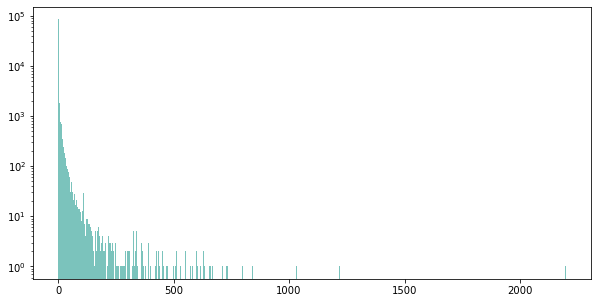

count    124341.000000
mean          5.848497
std          29.477340
min           1.000000
25%           1.000000
50%           1.000000
75%           2.000000
max        2198.000000
dtype: float64

There are 84512 single-article clusters and 39829 multiple-article clusters.
Showing 3 example cluster(s)...
--------------------------------------------------------------------------------
Example 0: the cluster contains 2198 documents.
Below are 5 docs from the cluster.

Titles:

["FBI Will Probe Minnesota Man's Death; Video Shows Cop's Knee on Man's Neck",
 'Video Surfaces Of Police Officer With Knee On Man’s Throat, Man Later Died',
 'Warriors’ Steve Kerr on Minnesota man’s police-involved death: ‘This is '
 'murder’',
 'Police Officers Involved With Death Of George Floyd Fired',
 'Four Minneapolis Cops Are Fired over the Death of a Handcuffed Black Man']

Publish dates:

['2020-05-26T16:34:58+00:00',
 '2020-05-26T16:40:10+00:00',
 '2020-05-26T18:51:21+00:00',
 '2020-05-26T20:41:55+00:

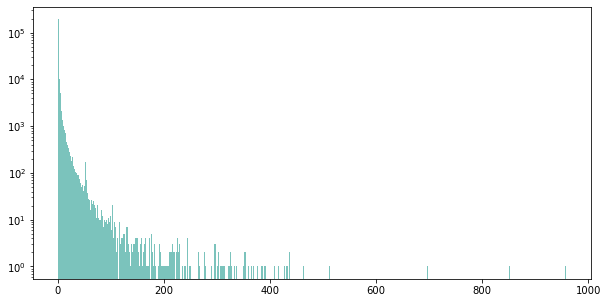

count    256469.000000
mean          2.835462
std          11.085022
min           1.000000
25%           1.000000
50%           1.000000
75%           2.000000
max         957.000000
dtype: float64

There are 192028 single-article clusters and 64441 multiple-article clusters.
Showing 3 example cluster(s)...
--------------------------------------------------------------------------------
Example 0: the cluster contains 957 documents.
Below are 5 docs from the cluster.

Titles:

["McLaughlin, Morris To Newsmax TV: Pollsters 'Suppressing' GOP Voters",
 'David Bossie: Trump will be reelected — here is his path to an Electoral '
 'College victory',
 'Celebrities voting for the first time in the 2020 presidential election',
 'ROGER STONE EXCLUSIVE: How the Democrats Plan to Steal the 2020 Election',
 'Election Day 3 days away: Trump, Biden barnstorm swing states']

Publish dates:

['2020-10-31T01:58:43+00:00',
 '2020-10-31T09:00:19+00:00',
 '2020-10-31T12:08:08+00:00',
 '2020-10-31T12:50:09

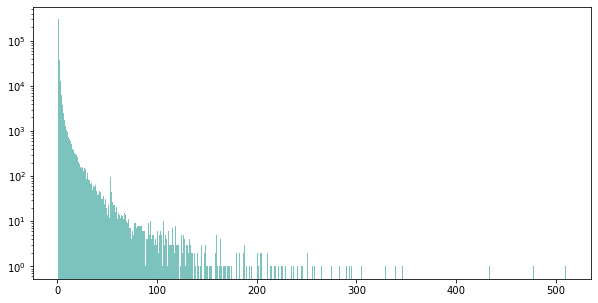

count    375878.000000
mean          1.934692
std           5.626378
min           1.000000
25%           1.000000
50%           1.000000
75%           1.000000
max         510.000000
dtype: float64

There are 299333 single-article clusters and 76545 multiple-article clusters.
Showing 3 example cluster(s)...
--------------------------------------------------------------------------------
Example 0: the cluster contains 510 documents.
Below are 5 docs from the cluster.

Titles:

['David Bossie: Trump will be reelected — here is his path to an Electoral '
 'College victory',
 'RNC Chair Ronna McDaniel: Republicans fighting Democratic attempts to steal '
 'election victory',
 'Late Ballots, Mismatched Signatures, Drop Boxes — Here’s How Hundreds Of '
 'Lawsuits Could Affect The Election’s Outcome',
 'REFILE-UPDATE 7-U.S. Early Voting Surges as Trump, Biden Make Late Push | '
 'Newsmax.com',
 'Trump launches final, two-day frenzy of campaigning in bid for surprise win']

Publish dates:

['

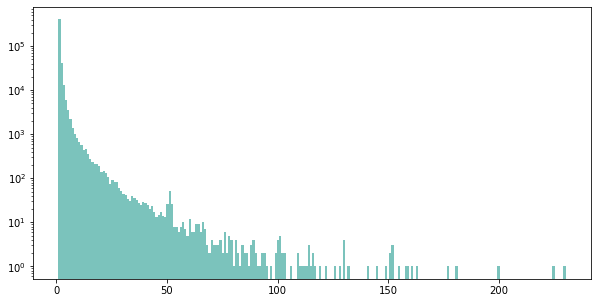

count    482010.000000
mean          1.508699
std           2.948789
min           1.000000
25%           1.000000
50%           1.000000
75%           1.000000
max         230.000000
dtype: float64

There are 405776 single-article clusters and 76234 multiple-article clusters.
Showing 3 example cluster(s)...
--------------------------------------------------------------------------------
Example 0: the cluster contains 230 documents.
Below are 5 docs from the cluster.

Titles:

['Late Ballots, Mismatched Signatures, Drop Boxes — Here’s How Hundreds Of '
 'Lawsuits Could Affect The Election’s Outcome',
 'Early voters cast record 92M ballots as Election Day nears',
 'Juan Williams: Trump and Republicans work to suppress Democratic votes',
 'Brian Arbour: What early voting numbers do and do not mean',
 'Justin Haskins: Early voting – Is US headed for post-election chaos?']

Publish dates:

['2020-11-01T00:57:23+00:00',
 '2020-11-01T09:12:54+00:00',
 '2020-11-01T11:00:42+00:00',
 '2020-11-

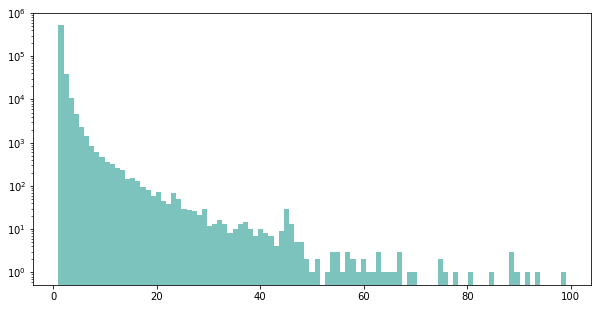

count    581120.000000
mean          1.251390
std           1.462473
min           1.000000
25%           1.000000
50%           1.000000
75%           1.000000
max          99.000000
dtype: float64

There are 518233 single-article clusters and 62887 multiple-article clusters.
Showing 3 example cluster(s)...
--------------------------------------------------------------------------------
Example 0: the cluster contains 99 documents.
Below are 5 docs from the cluster.

Titles:

['Members of Israeli parliament to Congress: Resolution opposing Israel '
 "boycott is 'dangerous to Israel'",
 "Israeli MKs: Two-State Solution 'Far More Dangerous' than BDS | Breitbart",
 'Bernie Sanders threatens to ‘leverage’ US aid to combat Israel ‘racism’',
 "Ilhan Omar accuses Israel of implementing 'Trump's Muslim ban' after being "
 'banned from the country',
 "'Their intent is to hurt Israel': Netanyahu addresses Tlaib and Omar ban"]

Publish dates:

['2019-08-13T05:35:36+00:00',
 '2019-08-14T05:05:18+

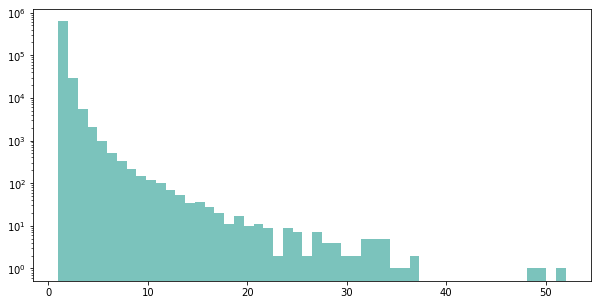

count    661795.000000
mean          1.098842
std           0.624923
min           1.000000
25%           1.000000
50%           1.000000
75%           1.000000
max          52.000000
dtype: float64

There are 622726 single-article clusters and 39069 multiple-article clusters.
Showing 3 example cluster(s)...
--------------------------------------------------------------------------------
Example 0: the cluster contains 52 documents.
Below are 5 docs from the cluster.

Titles:

["Ilhan Omar accuses Israel of implementing 'Trump's Muslim ban' after being "
 'banned from the country',
 "'Their intent is to hurt Israel': Netanyahu addresses Tlaib and Omar ban",
 'Update: Israel Bars Ilhan Omar, Rashida Tlaib from Israel',
 'Trump Jumps On Reports Of Israel Banning Reps. Omar And Tlaib: &#8216;They '
 'Hate &#8230; All Jewish People&#8217;',
 "Donald Trump Says Israel Should Block Omar, Tlaib: They Hate 'All Jewish "
 "People'"]

Publish dates:

['2019-08-15T04:00:00+00:00',
 '2019-08-15T04

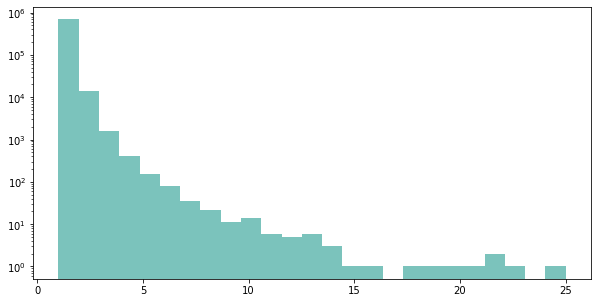

count    706965.000000
mean          1.028634
std           0.232292
min           1.000000
25%           1.000000
50%           1.000000
75%           1.000000
max          25.000000
dtype: float64

There are 690750 single-article clusters and 16215 multiple-article clusters.
Showing 3 example cluster(s)...
--------------------------------------------------------------------------------
Example 0: the cluster contains 25 documents.
Below are 5 docs from the cluster.

Titles:

['Soldiers seize Zimbabwe state broadcaster, anti-Mugabe coup talk intensifies',
 'US tells citizens in Zimbabwe to shelter in place as troops seen in capital',
 'Apparent Coup in Zimbabwe as Robert Mugabe in Military Custody | Breitbart',
 'Zimbabwe army seizes control but denies coup; Mugabe detained',
 "Robert Mugabe's ruthless 37-year reign in Zimbabwe appears near end"]

Publish dates:

['2017-11-15T00:35:26+00:00',
 '2017-11-15T02:00:00+00:00',
 '2017-11-15T10:02:48+00:00',
 '2017-11-15T10:45:00+00:00',
 '2

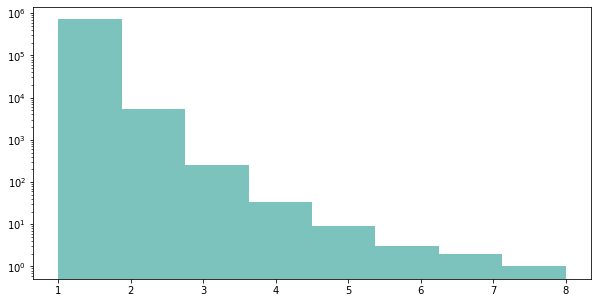

count    721304.000000
mean          1.008185
std           0.097264
min           1.000000
25%           1.000000
50%           1.000000
75%           1.000000
max           8.000000
dtype: float64

There are 715770 single-article clusters and 5534 multiple-article clusters.
Showing 3 example cluster(s)...
--------------------------------------------------------------------------------
Example 0: the cluster contains 8 documents.
Below are 5 docs from the cluster.

Titles:

['MLB roundup: Dodgers rally, hang on in 10th',
 'MLB roundup: Braves set NL runs record in 29-9 rout',
 'MLB roundup: Royals’ Singer take no-no into 8th, beats Indians',
 'MLB roundup: Blackmon, Rockies slam past Angels',
 'MLB roundup: Astros rally past Dodgers in ninth']

Publish dates:

['2020-09-09T08:04:21+00:00',
 '2020-09-10T06:18:57+00:00',
 '2020-09-11T08:02:57+00:00',
 '2020-09-12T08:00:29+00:00',
 '2020-09-13T06:45:24+00:00']

IDs:

['OneAmericaNews_1706006416',
 'OneAmericaNews_1706991682',
 'OneAmeric

In [17]:
print_gridreport(gridresults, n_clusters=3, n_hits=5, export_clusters=True)